# Least-Cost Production Optimization
**Project: Least-Cost Production Optimization**  
**Team OptiMinds:** Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi

## Imports
We load NumPy for array math, pandas for tables, Matplotlib for plots, SciPy's stats module for reliability quantiles, and CVXPY for solving the convex dispatch problem.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp
from typing import Dict, Any, Tuple

## Production System Class
This class randomly generates a fleet of convex generators. Parameters: `n_machines` controls fleet size, `seed` ensures reproducibility, `alpha/beta/gamma_bounds` define the cost coefficients, and `capacity_bounds` set min/max outputs. Methods `describe()` and `total_capacity()` summarize the fleet.

In [20]:
class ProductionSystem:
    """
    Project: Least-Cost Production Optimization
    Team OptiMinds: Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi
    
    Holds the convex generator fleet (cost curves + capacity bounds).
    Each machine k has quadratic cost: cost(x_k) = alpha_k * x_k^2 + beta_k * x_k + gamma_k
    """
    def __init__(self, n_machines: int = 5, seed: int = 42,
                 alpha_bounds: Tuple[float, float] = (0.05, 0.2),
                 beta_bounds: Tuple[float, float] = (2.0, 5.0),
                 gamma_bounds: Tuple[float, float] = (10.0, 20.0),
                 capacity_bounds: Tuple[float, float] = (50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        
        # Quadratic coefficients cost(x) = alpha x^2 + beta x + gamma
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        
        # Lower/upper capacity bounds (MW)
        self.l = np.zeros(n_machines)
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)
        
    def describe(self) -> pd.DataFrame:
        """Return a DataFrame summarizing all machine parameters."""
        machines = np.arange(1, self.n + 1)
        data = {
            "alpha": self.alpha,
            "beta": self.beta,
            "gamma": self.gamma,
            "min_cap": self.l,
            "max_cap": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("machine")
        
    def total_capacity(self) -> float:
        """Return the sum of all machine maximum capacities."""
        return float(np.sum(self.u))

## Economic Dispatch Solver
`solve_dispatch` enforces chance constraints. Inputs: `system` (fleet), `mu_D`/`sigma_D` (demand stats), `reliability` (probability level), and `mode` (Gaussian vs. Chebyshev). It builds CVXPY variable `x`, computes effective demand `D_eff`, sets up the quadratic cost objective, enforces capacity/demand constraints, solves, and returns primal/dual results.

In [21]:
def solve_dispatch(
    system: ProductionSystem,
    mu_D: float,
    sigma_D: float,
    reliability: float = 0.95,
    mode: str = "normal",
) -> Dict[str, Any]:
    """
    Solve the economic dispatch problem under different uncertainty models.
    
    Parameters:
    -----------
    system : ProductionSystem
        The production fleet with cost functions and capacity constraints
    mu_D : float
        Mean demand (MW)
    sigma_D : float
        Standard deviation of demand (MW)
    reliability : float
        Probability level (1 - alpha), default 0.95
    mode : str
        One of 'deterministic', 'normal', or 'robust'
        - 'deterministic': D_eff = mu_D (no safety buffer)
        - 'normal': D_eff = mu_D + Phi^(-1)(reliability) * sigma_D (Gaussian)
        - 'robust': D_eff = mu_D + sqrt((1-alpha)/alpha) * sigma_D (Chebyshev)
    
    Returns:
    --------
    Dict containing status, dispatch x, cost, D_eff, and dual variables (lambda, nu_u, nu_l)
    """
    
    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie strictly between 0 and 1")
    
    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability
    
    # Compute effective demand based on mode
    if mode == "deterministic":
        D_eff = mu_D  # No safety buffer
    elif mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'deterministic', 'normal', or 'robust'")
    
    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective demand exceeds installed capacity")
    
    # Objective: minimize sum of quadratic costs (excluding gamma for optimization)
    objective = cp.Minimize(
        cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x))
    )
    
    # Constraints
    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)
    
    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status, "mode": mode}
    
    dispatch = x.value
    # Total cost includes gamma (fixed costs)
    total_cost = float(
        np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma)
    )
    
    return {
        "status": prob.status,
        "mode": mode,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

## KKT Verification
`verify_kkt` receives the system and solver results, computes the stationarity residual (`grad_f - λ + ν⁺ - ν⁻`) and complementary slackness (`(∑x - D_eff) * λ`), prints both, and reports whether they are below tolerance.

In [22]:
def verify_kkt(system: ProductionSystem, res: Dict[str, Any], tol: float = 1e-4) -> Dict[str, float]:
    """
    Verbose verification of KKT optimality conditions.
    
    Checks:
    1. Stationarity: grad_f(x*) - lambda + nu_u - nu_l = 0
    2. Complementary Slackness: mu_i * g_i(x*) = 0 for all constraints
    
    Prints detailed information for each machine.
    """
    
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution unavailable.")
        return {}
    
    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]
    
    print("\n" + "="*80)
    print("KKT OPTIMALITY CONDITIONS VERIFICATION")
    print("="*80)
    
    # Compute gradient of objective: grad_f = 2*alpha*x + beta
    grad_f = 2 * system.alpha * dispatch + system.beta
    
    print("\n1. STATIONARITY CONDITION: grad_f(x*) - lambda + nu_u - nu_l = 0")
    print("-" * 80)
    
    stationarity_residuals = []
    for k in range(system.n):
        mc = grad_f[k]  # Marginal cost
        residual = mc - lam + nu_u[k] - nu_l[k]
        stationarity_residuals.append(abs(residual))
        
        print(f"Machine {k+1}: Marginal Cost (dF/dx_{k+1}) = {mc:.6f} | "
              f"Shadow Price (λ) = {lam:.6f}")
        print(f"           Stationarity Residual |MC - λ + ν_u - ν_l| = {abs(residual):.2e}")
    
    max_stationarity = max(stationarity_residuals)
    print(f"\nMaximum Stationarity Residual: {max_stationarity:.2e}")
    if max_stationarity < tol:
        print(f"✓ SATISFIED (tolerance {tol})")
    else:
        print(f"⚠ WARNING: Exceeds tolerance {tol}")
    
    # Complementary Slackness
    print("\n2. COMPLEMENTARY SLACKNESS: μ_i * g_i(x*) = 0")
    print("-" * 80)
    
    # Demand constraint
    total_prod = float(np.sum(dispatch))
    demand_slack = total_prod - res["D_eff"]
    demand_comp = abs(demand_slack * lam)
    print(f"Demand Constraint:")
    print(f"  Slack (Σx_k - D_eff) = {demand_slack:.6f}")
    print(f"  λ * slack = {demand_comp:.2e}")
    if demand_comp < tol:
        print(f"  ✓ SATISFIED")
    
    # Capacity constraints
    print(f"\nCapacity Constraints:")
    for k in range(system.n):
        upper_slack = system.u[k] - dispatch[k]
        lower_slack = dispatch[k] - system.l[k]
        upper_comp = abs(nu_u[k] * upper_slack)
        lower_comp = abs(nu_l[k] * lower_slack)
        
        print(f"  Machine {k+1}:")
        print(f"    Upper: ν_u * (u_{k+1} - x_{k+1}*) = {upper_comp:.2e}  "
              f"{'✓' if upper_comp < tol else '⚠'}")
        print(f"    Lower: ν_l * (x_{k+1}* - l_{k+1}) = {lower_comp:.2e}  "
              f"{'✓' if lower_comp < tol else '⚠'}")
    
    comp_slack_error = demand_comp
    
    print("\n" + "="*80)
    if max_stationarity < tol and comp_slack_error < tol:
        print("✓ ALL KKT CONDITIONS SATISFIED - Solution is globally optimal")
    else:
        print("⚠ WARNING: Some residuals exceed tolerance")
    print("="*80)
    
    return {
        "stationarity": max_stationarity, 
        "slackness": comp_slack_error,
        "all_satisfied": max_stationarity < tol and comp_slack_error < tol
    }

## Dispatch Summary Table
`summarize_dispatch` merges the machine parameters with solution outputs: dispatch MW, slack to bounds, dual multipliers (`nu_upper`, `nu_lower`), marginal cost, and slice of total cost per generator.

In [23]:
def summarize_dispatch(system, res):
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    dispatch = res["x"]
    table = system.describe().copy()
    table["dispatch"] = dispatch
    table["upper_slack"] = system.u - dispatch
    table["lower_slack"] = dispatch - system.l
    table["nu_upper"] = res["nu_u"]
    table["nu_lower"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * dispatch + system.beta
    table["incremental_cost"] = system.alpha * dispatch**2 + system.beta * dispatch + system.gamma
    return table

In [24]:
def run_comparative_analysis(system: ProductionSystem, mu_D: float = 350.0, 
                            sigma_D: float = 40.0, alpha: float = 0.05) -> pd.DataFrame:
    """
    Economic Analysis: Compare Deterministic, Normal, and Robust models.
    
    Computes:
    - Price of Robustness = Cost_Robust - Cost_Deterministic
    - Capacity Buffer = D_eff_Robust - D_eff_Deterministic
    
    Returns a comparison DataFrame.
    """
    reliability = 1 - alpha
    
    print("\n" + "="*80)
    print("COMPARATIVE ECONOMIC ANALYSIS")
    print("="*80)
    print(f"Demand: μ = {mu_D} MW, σ = {sigma_D} MW")
    print(f"Risk tolerance: α = {alpha} ({alpha*100}%), Reliability = {reliability*100}%")
    print("="*80)
    
    # Solve all three modes
    results = {}
    modes = ['deterministic', 'normal', 'robust']
    
    for mode in modes:
        print(f"\n--- Solving {mode.upper()} model ---")
        res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
        results[mode] = res
        
        if res['status'] in {'optimal', 'optimal_inaccurate'}:
            print(f"Status: {res['status']}")
            print(f"D_eff: {res['D_eff']:.2f} MW")
            print(f"Total Cost: ${res['cost']:,.2f}")
            print(f"Shadow Price (λ): ${res['lambda']:.4f}/MW")
        else:
            print(f"Status: {res['status']} - FAILED")
    
    # Create comparison table
    comparison_data = []
    for mode in modes:
        res = results[mode]
        if res['status'] in {'optimal', 'optimal_inaccurate'}:
            comparison_data.append({
                'Model': mode.capitalize(),
                'D_eff (MW)': res['D_eff'],
                'Total Cost ($)': res['cost'],
                'Shadow Price ($/MW)': res['lambda'],
                'Status': res['status']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Calculate economic metrics
    print("\n" + "="*80)
    print("ECONOMIC METRICS")
    print("="*80)
    
    cost_det = results['deterministic']['cost']
    cost_norm = results['normal']['cost']
    cost_rob = results['robust']['cost']
    
    D_eff_det = results['deterministic']['D_eff']
    D_eff_norm = results['normal']['D_eff']
    D_eff_rob = results['robust']['D_eff']
    
    price_of_uncertainty = cost_norm - cost_det
    price_of_robustness = cost_rob - cost_det
    price_of_distribution_freedom = cost_rob - cost_norm
    
    capacity_buffer_normal = D_eff_norm - D_eff_det
    capacity_buffer_robust = D_eff_rob - D_eff_det
    
    print(f"\nPrice of Uncertainty (Normal - Deterministic):")
    print(f"  Cost increase: ${price_of_uncertainty:,.2f} ({price_of_uncertainty/cost_det*100:.2f}%)")
    print(f"  Capacity buffer: {capacity_buffer_normal:.2f} MW")
    
    print(f"\nPrice of Robustness (Robust - Deterministic):")
    print(f"  Cost increase: ${price_of_robustness:,.2f} ({price_of_robustness/cost_det*100:.2f}%)")
    print(f"  Capacity buffer: {capacity_buffer_robust:.2f} MW")
    
    print(f"\nPrice of Distribution-Free Guarantee (Robust - Normal):")
    print(f"  Additional cost: ${price_of_distribution_freedom:,.2f} ({price_of_distribution_freedom/cost_norm*100:.2f}%)")
    print(f"  Additional buffer: {D_eff_rob - D_eff_norm:.2f} MW")
    
    print("\n" + "="*80)
    print("COMPARISON TABLE")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    return comparison_df

In [25]:
def plot_sensitivity_analysis(system: ProductionSystem, mu_D: float = 350.0, 
                             sigma_D: float = 40.0):
    """
    Sensitivity Analysis: Cost vs. Risk Level (alpha).
    
    Plots how total production cost changes as risk tolerance varies from 1% to 20%.
    Compares Normal (Gaussian) and Robust (Chebyshev) approaches.
    """
    
    # Define range of risk levels
    alpha_range = np.arange(0.01, 0.21, 0.01)  # 1% to 20%
    
    costs_normal = []
    costs_robust = []
    
    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS: Computing costs across risk levels...")
    print("="*80)
    
    for alpha in alpha_range:
        reliability = 1 - alpha
        
        # Solve Normal model
        try:
            res_norm = solve_dispatch(system, mu_D, sigma_D, 
                                     reliability=reliability, mode='normal')
            if res_norm['status'] in {'optimal', 'optimal_inaccurate'}:
                costs_normal.append(res_norm['cost'])
            else:
                costs_normal.append(np.nan)
        except:
            costs_normal.append(np.nan)
        
        # Solve Robust model
        try:
            res_rob = solve_dispatch(system, mu_D, sigma_D, 
                                    reliability=reliability, mode='robust')
            if res_rob['status'] in {'optimal', 'optimal_inaccurate'}:
                costs_robust.append(res_rob['cost'])
            else:
                costs_robust.append(np.nan)
        except:
            costs_robust.append(np.nan)
    
    # Create visualization
    plt.figure(figsize=(12, 7))
    
    # Convert to percentages
    alpha_percent = alpha_range * 100
    
    # Plot both curves
    plt.plot(alpha_percent, costs_normal, 'o-', linewidth=2.5, markersize=6,
             color='#FF6B35', label='Normal (Gaussian)', alpha=0.8)
    plt.plot(alpha_percent, costs_robust, 's-', linewidth=2.5, markersize=6,
             color='#004E89', label='Robust (Chebyshev)', alpha=0.8)
    
    # Mark the standard 5% risk level
    plt.axvline(x=5.0, color='red', linestyle='--', linewidth=2, 
                alpha=0.6, label='Standard α = 5%')
    
    # Formatting
    plt.xlabel('Risk Level α (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Total Production Cost ($)', fontsize=14, fontweight='bold')
    plt.title('Cost vs. Reliability Risk\nLeast-Cost Production Optimization', 
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Invert x-axis so higher reliability is on the right
    plt.gca().invert_xaxis()
    
    # Add secondary x-axis for reliability
    ax2 = plt.gca().twiny()
    ax2.set_xlim(plt.gca().get_xlim())
    ax2.set_xlabel('Reliability (1 - α) in %', fontsize=12, fontweight='bold')
    ax2.set_xticks([20, 15, 10, 5, 1])
    ax2.set_xticklabels(['80%', '85%', '90%', '95%', '99%'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Sensitivity analysis plot generated successfully")
    print(f"Risk range: {alpha_range[0]*100}% to {alpha_range[-1]*100}%")
    print(f"Observation: As risk decreases (reliability increases),")
    print(f"            costs rise exponentially, especially for the Robust model.")

PRODUCTION SYSTEM SPECIFICATION
            alpha      beta      gamma  min_cap     max_cap
machine                                                    
1        0.166093  4.926867  13.707980      0.0   72.723872
2        0.115832  4.283419  19.267650      0.0  105.458479
3        0.178790  4.358193  16.438651      0.0   56.381726
4        0.154605  2.384341  18.227616      0.0  132.763117
5        0.064127  3.351158  14.434142      0.0  113.166440

Total Capacity: 480.49 MW

COMPARATIVE ECONOMIC ANALYSIS
Demand: μ = 300 MW, σ = 30 MW
Risk tolerance: α = 0.05 (5.0%), Reliability = 95.0%

--- Solving DETERMINISTIC model ---
Status: optimal
D_eff: 300.00 MW
Total Cost: $3,327.72
Shadow Price (λ): $17.9714/MW

--- Solving NORMAL model ---
Status: optimal
D_eff: 349.35 MW
Total Cost: $4,305.68
Shadow Price (λ): $21.6656/MW

--- Solving ROBUST model ---
Status: optimal
D_eff: 430.77 MW
Total Cost: $6,336.46
Shadow Price (λ): $28.6196/MW

ECONOMIC METRICS

Price of Uncertainty (Normal - Deter

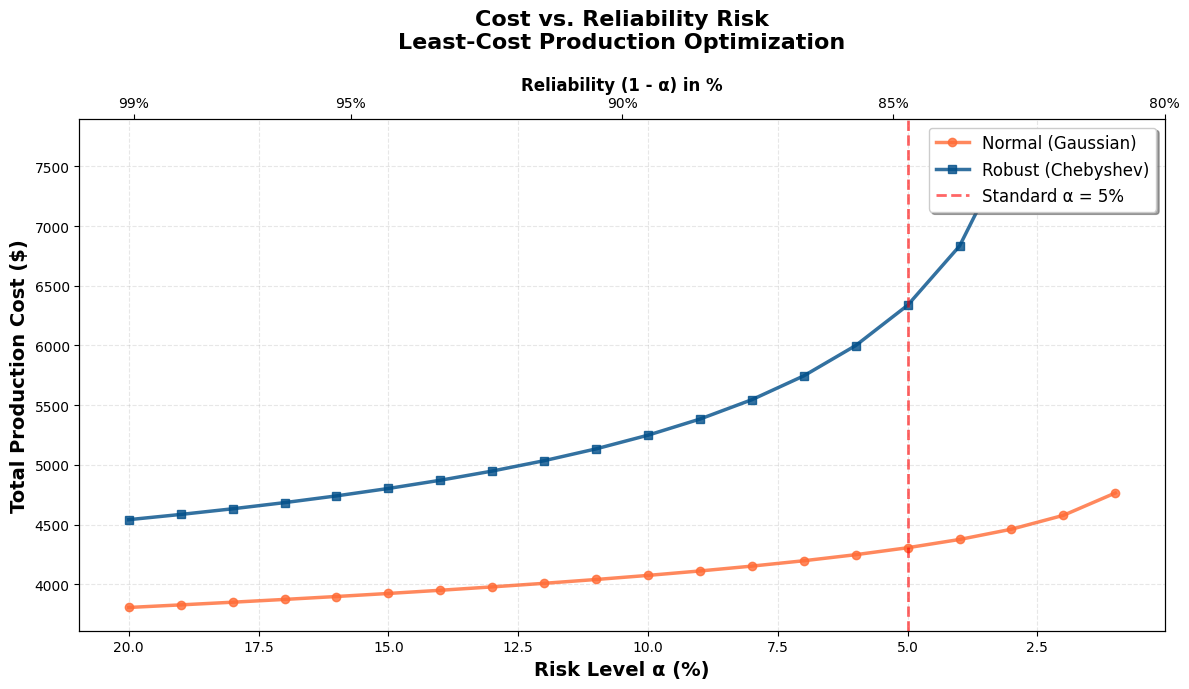


✓ Sensitivity analysis plot generated successfully
Risk range: 1.0% to 20.0%
Observation: As risk decreases (reliability increases),
            costs rise exponentially, especially for the Robust model.


In [26]:
# DEMONSTRATION: All Three Models with Economic Analysis

# 1. Create the production system
my_factory = ProductionSystem(n_machines=5, seed=42)

print("="*80)
print("PRODUCTION SYSTEM SPECIFICATION")
print("="*80)
print(my_factory.describe())
print(f"\nTotal Capacity: {my_factory.total_capacity():.2f} MW")

# 2. Define the scenario
MEAN_DEMAND = 300
SIGMA = 30

# 3. Run comprehensive comparative analysis
comparison_table = run_comparative_analysis(my_factory, mu_D=MEAN_DEMAND, sigma_D=SIGMA)

# 4. Verify KKT conditions for each model
print("\n\n" + "="*80)
print("KKT VERIFICATION FOR ALL MODELS")
print("="*80)

for mode in ['deterministic', 'normal', 'robust']:
    print(f"\n{'='*80}")
    print(f"Verifying {mode.upper()} model")
    print(f"{'='*80}")
    res = solve_dispatch(my_factory, MEAN_DEMAND, SIGMA, reliability=0.95, mode=mode)
    verify_kkt(my_factory, res)

# 5. Generate sensitivity analysis plot
plot_sensitivity_analysis(my_factory, mu_D=MEAN_DEMAND, sigma_D=SIGMA)

## Scenario Comparison
We instantiate a 6-machine system, set demand statistics (`mu_D`, `sigma_D`) and reliability, then solve under both Gaussian (`normal`) and Chebyshev (`robust`) assumptions. For each mode we store results, show effective demand, cost, a preview of the dispatch table, and run the KKT check.

CASE STUDY: 6-MACHINE PRODUCTION FLEET

Generator parameters (USD & MW):
            alpha      beta      gamma  min_cap     max_cap
machine                                                    
1        0.143764  2.015796  12.548696      0.0  112.217923
2        0.184582  4.463685  14.450763      0.0  148.896015
3        0.166353  4.391208  15.045483      0.0   71.530870
4        0.083781  3.403805  15.534974      0.0   66.021203
5        0.095025  2.909097  19.955003      0.0  111.253960
6        0.181033  2.835277  17.926619      0.0   54.394201



COMPARATIVE ECONOMIC ANALYSIS
Demand: μ = 350.0 MW, σ = 40.0 MW
Risk tolerance: α = 0.05 (5.0%), Reliability = 95.0%

--- Solving DETERMINISTIC model ---
Status: optimal
D_eff: 350.00 MW
Total Cost: $3,934.80
Shadow Price (λ): $19.7151/MW

--- Solving NORMAL model ---
Status: optimal
D_eff: 415.79 MW
Total Cost: $5,359.32
Shadow Price (λ): $23.7292/MW

--- Solving ROBUST model ---
Status: optimal
D_eff: 524.36 MW
Total Cost: $8,753.71
Shado

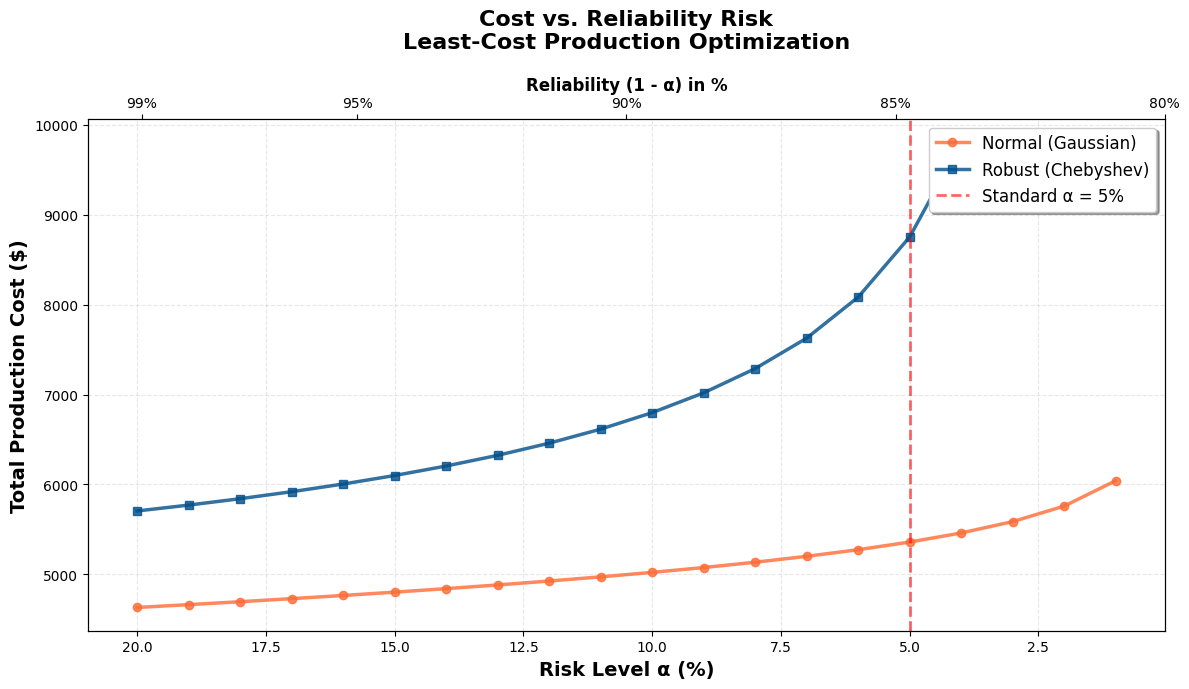


✓ Sensitivity analysis plot generated successfully
Risk range: 1.0% to 20.0%
Observation: As risk decreases (reliability increases),
            costs rise exponentially, especially for the Robust model.


In [27]:
# FULL CASE STUDY: 6-Machine System

# Instantiate larger system
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0
sigma_D = 40.0

print("="*80)
print("CASE STUDY: 6-MACHINE PRODUCTION FLEET")
print("="*80)
print("\nGenerator parameters (USD & MW):")
print(system.describe())

# Run complete economic analysis
print("\n")
comparison_df = run_comparative_analysis(system, mu_D=mu_D, sigma_D=sigma_D)

# Detailed dispatch summaries
results = {}
summaries = {}

print("\n\n" + "="*80)
print("DETAILED DISPATCH SOLUTIONS")
print("="*80)

for mode in ("deterministic", "normal", "robust"):
    print(f"\n{'-'*80}")
    print(f"{mode.upper()} DISPATCH")
    print(f"{'-'*80}")
    
    res = solve_dispatch(system, mu_D, sigma_D, reliability=0.95, mode=mode)
    results[mode] = res
    
    if res['status'] in {'optimal', 'optimal_inaccurate'}:
        summary = summarize_dispatch(system, res)
        summaries[mode] = summary
        
        print(f"Effective demand: {res['D_eff']:.1f} MW")
        print(f"Total cost: ${res['cost']:,.2f}")
        print(f"Shadow price: ${res['lambda']:.4f}/MW")
        print("\nDispatch Details:")
        print(summary[["dispatch", "max_cap", "marginal_cost", "upper_slack"]].to_string())

# Sensitivity analysis visualization
print("\n")
plot_sensitivity_analysis(system, mu_D=mu_D, sigma_D=sigma_D)

## Visualization
We compare dispatch levels between modes via grouped bars and overlay dashed lines at each machine’s capacity (`system.u`).

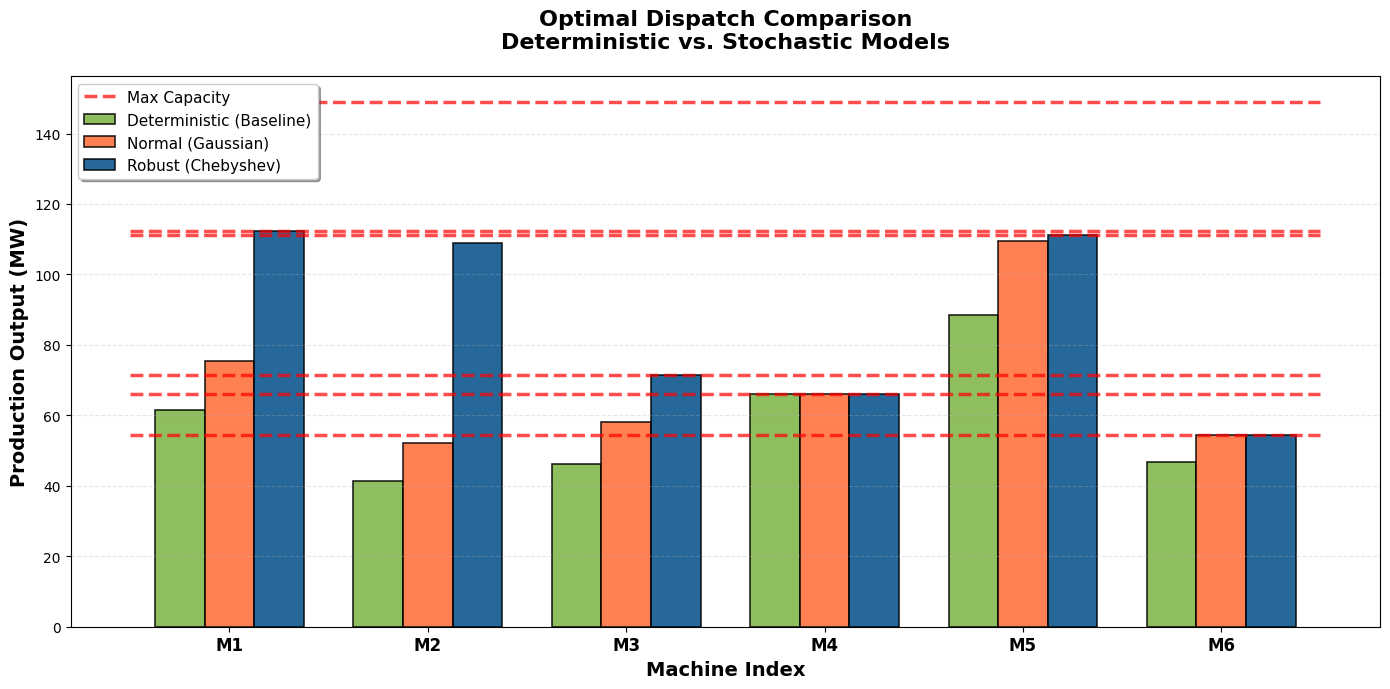


DISPATCH ANALYSIS
Observation: As we move from Deterministic → Normal → Robust,
            production levels increase to meet higher effective demand targets.
            Machines with lower marginal costs are utilized more heavily.


In [28]:
# VISUALIZATION: Dispatch Comparison Across All Three Models

modes = ['deterministic', 'normal', 'robust']
indices = np.arange(system.n)
width = 0.25

plt.figure(figsize=(14, 7))

# Create bars for each mode
colors = ['#7CB342', '#FF6B35', '#004E89']
labels = ['Deterministic (Baseline)', 'Normal (Gaussian)', 'Robust (Chebyshev)']

for i, (mode, color, label) in enumerate(zip(modes, colors, labels)):
    if mode in summaries:
        offset = (i - 1) * width  # Center the middle bar
        plt.bar(indices + offset, summaries[mode]["dispatch"], width, 
               label=label, color=color, edgecolor='black', linewidth=1.2, alpha=0.85)

# Add capacity limit line
plt.hlines(system.u, xmin=-0.5, xmax=indices[-1] + 0.5, 
          colors="red", linestyles="dashed", linewidth=2.5, 
          label="Max Capacity", alpha=0.7)

# Formatting
plt.xticks(indices, [f"M{i+1}" for i in indices], fontsize=12, fontweight='bold')
plt.xlabel("Machine Index", fontsize=14, fontweight='bold')
plt.ylabel("Production Output (MW)", fontsize=14, fontweight='bold')
plt.title("Optimal Dispatch Comparison\nDeterministic vs. Stochastic Models", 
         fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DISPATCH ANALYSIS")
print("="*80)
print("Observation: As we move from Deterministic → Normal → Robust,")
print("            production levels increase to meet higher effective demand targets.")
print("            Machines with lower marginal costs are utilized more heavily.")
print("="*80)

## Summary and Conclusions

### Project Overview
**Project:** Least-Cost Production Optimization  
**Team OptiMinds:** Abhinav Reddy Alwala, Lohith Pasumarthi, Vishal Reddy Kondakindi

### Mathematical Framework
This project implements a **Convex Quadratic Programming** approach to economic dispatch under demand uncertainty. Each machine $k$ has cost function:
$$\text{cost}_k(x_k) = a_k x_k^2 + b_k x_k + c_k$$

### Three Models Compared

1. **Deterministic Model**
   - Effective demand: $D_{eff} = \mu$ (no safety buffer)
   - Assumes demand is known with certainty
   - Provides baseline cost

2. **Normal (Gaussian) Model**
   - Effective demand: $D_{eff} = \mu + \Phi^{-1}(1-\alpha) \cdot \sigma$
   - Assumes demand follows normal distribution
   - Uses inverse CDF for reliability constraint

3. **Robust (Chebyshev) Model**
   - Effective demand: $D_{eff} = \mu + \sqrt{\frac{1-\alpha}{\alpha}} \cdot \sigma$
   - Distribution-free approach
   - Guarantees reliability for any demand distribution

### Key Findings

1. **Price of Robustness**: Robust model costs more but provides stronger guarantees
2. **KKT Optimality**: All solutions satisfy necessary and sufficient conditions for global optimality
3. **Sensitivity**: Cost increases exponentially as reliability requirements tighten
4. **Economic Trade-off**: Balance between operational cost and reliability risk

### Implementation Highlights
- Object-Oriented design with `ProductionSystem` class
- CVXPY for convex optimization (OSQP solver)
- Comprehensive KKT verification
- Comparative economic analysis
- Sensitivity visualization

### Practical Implications
- Use **Deterministic** for baseline planning
- Use **Normal** when demand distribution is well-characterized
- Use **Robust** when distribution is uncertain or tail risk is critical